In [1]:
data_raw = sc.textFile('data/201508_trip_data.csv.gz')

In [2]:
data_raw.take(5)

[u'Trip ID,Duration,Start Date,Start Station,Start Terminal,End Date,End Station,End Terminal,Bike #,Subscriber Type,Zip Code',
 u'913460,765,8/31/2015 23:26,Harry Bridges Plaza (Ferry Building),50,8/31/2015 23:39,San Francisco Caltrain (Townsend at 4th),70,288,Subscriber,2139',
 u'913459,1036,8/31/2015 23:11,San Antonio Shopping Center,31,8/31/2015 23:28,Mountain View City Hall,27,35,Subscriber,95032',
 u'913455,307,8/31/2015 23:13,Post at Kearny,47,8/31/2015 23:18,2nd at South Park,64,468,Subscriber,94107',
 u'913454,409,8/31/2015 23:10,San Jose City Hall,10,8/31/2015 23:17,San Salvador at 1st,8,68,Subscriber,95113']

In [3]:
from pyspark.sql import Row

In [4]:
import numpy as np

In [5]:
dates = (data_raw
         .map(lambda x: x.split(','))
         .map(lambda x: x[2]))

In [6]:
dates.take(5)

[u'Start Date',
 u'8/31/2015 23:26',
 u'8/31/2015 23:11',
 u'8/31/2015 23:13',
 u'8/31/2015 23:10']

In [7]:
from datetime import datetime, timedelta

In [8]:
def convert_date(date_str):
    try:
        return datetime.strptime(date_str, '%m/%d/%Y %H:%M')
    except ValueError:
        return None

In [9]:
dates = (dates
        .map(lambda x: convert_date(x))
        .filter(lambda x: x != None))

In [10]:
dates.take(5)

[datetime.datetime(2015, 8, 31, 23, 26),
 datetime.datetime(2015, 8, 31, 23, 11),
 datetime.datetime(2015, 8, 31, 23, 13),
 datetime.datetime(2015, 8, 31, 23, 10),
 datetime.datetime(2015, 8, 31, 23, 9)]

## For Grownups: The Spark Way

In [11]:
from operator import add

In [12]:
whole_hours = dates.map(lambda x: datetime(x.year, x.month, x.day, x.hour))

In [13]:
whole_hours = whole_hours.cache()

In [14]:
min_date, max_date = whole_hours.min(), whole_hours.max()

In [15]:
min_date, max_date

(datetime.datetime(2014, 9, 1, 0, 0), datetime.datetime(2015, 8, 31, 23, 0))

In [16]:
from datetime import timedelta

In [17]:
hours = [min_date]
while hours[-1] < max_date:
    hours.append(hours[-1] + timedelta(hours=1))

In [18]:
all_hours = sc.parallelize(((d, 0) for d in hours))

In [19]:
hourly_counts = whole_hours.map(lambda x: (x, 1)).reduceByKey(add).cache()

In [20]:
hourly_counts.take(5)

[(datetime.datetime(2014, 11, 17, 21, 0), 14),
 (datetime.datetime(2015, 7, 10, 10, 0), 55),
 (datetime.datetime(2014, 10, 14, 10, 0), 53),
 (datetime.datetime(2014, 11, 25, 19, 0), 35),
 (datetime.datetime(2015, 7, 14, 8, 0), 210)]

In [21]:
full_counts = all_hours.leftOuterJoin(hourly_counts).map(lambda (k, v): (k, max(v))).cache()

In [22]:
full_counts.take(5)

[(datetime.datetime(2014, 9, 21, 9, 0), 26),
 (datetime.datetime(2015, 3, 30, 21, 0), 22),
 (datetime.datetime(2015, 8, 31, 19, 0), 72),
 (datetime.datetime(2014, 9, 30, 4, 0), 1),
 (datetime.datetime(2015, 3, 12, 0, 0), 5)]

In [23]:
shifts = (timedelta(hours=1), timedelta(days=1), timedelta(days=7), timedelta(days=14), timedelta(days=28))

In [24]:
data = full_counts.map(lambda (d, c): (d, (c,)))
for shift in shifts:
    data = (data.join(full_counts.map(lambda (d, c) : (d + shift, c)))
                     .map(lambda (d, (t, v)): (d, t+(v,))))
data = data.cache()

In [25]:
data.take(5)

[(datetime.datetime(2015, 2, 12, 0, 0), (4, 9, 3, 3, 4, 1)),
 (datetime.datetime(2015, 3, 7, 10, 0), (28, 24, 41, 16, 24, 28)),
 (datetime.datetime(2014, 12, 18, 9, 0), (119, 176, 93, 9, 119, 113)),
 (datetime.datetime(2015, 6, 24, 18, 0), (137, 192, 132, 128, 118, 137)),
 (datetime.datetime(2015, 6, 6, 20, 0), (16, 29, 11, 8, 11, 12))]

In [26]:
from pyspark.ml.linalg import Vectors

In [27]:
X = spark.createDataFrame(data.map(lambda (d, v): Row(date=d, features=Vectors.dense(v[1:]), label=v[0])))

In [28]:
X.show(5)

+--------------------+--------------------+-----+
|                date|            features|label|
+--------------------+--------------------+-----+
|2015-02-12 00:00:...|[9.0,3.0,3.0,4.0,...|    4|
|2015-03-07 10:00:...|[24.0,41.0,16.0,2...|   28|
|2014-12-18 09:00:...|[176.0,93.0,9.0,1...|  119|
|2015-06-24 18:00:...|[192.0,132.0,128....|  137|
|2015-06-06 20:00:...|[29.0,11.0,8.0,11...|   16|
+--------------------+--------------------+-----+
only showing top 5 rows



In [29]:
from pyspark.ml.regression import DecisionTreeRegressor

In [30]:
split_point = datetime(2015,8,21)
Xtr = X.filter(X.date < split_point)
Xte = X.filter(X.date >= split_point)

In [31]:
ds = range(2, 20, 2)
models = [DecisionTreeRegressor(maxDepth=d).fit(Xtr) for d in ds]

In [32]:
p = models[0].transform(Xte)

In [33]:
p.columns

['date', 'features', 'label', 'prediction']

In [34]:
p.select((p.label - p.prediction)**2).show(5)

+------------------------------+
|POWER((label - prediction), 2)|
+------------------------------+
|             598.3723101023917|
|             35.53551890298493|
|             726.6508750983389|
|              48.4578540606602|
|            3.8461782722838653|
+------------------------------+
only showing top 5 rows



In [35]:
from pyspark.sql import functions as fn

In [36]:
def get_mse(rdd):
    mse_df = rdd.agg(fn.mean((rdd.label - rdd.prediction)**2).alias('mse'))
    return mse_df.collect()[0].mse

In [37]:
get_mse(p)

240.0620600927008

In [38]:
mses = [get_mse(model.transform(Xte)) for model in models]
mse_train = [get_mse(model.transform(Xtr)) for model in models]

In [40]:
import matplotlib.pyplot as plt
%matplotlib inline

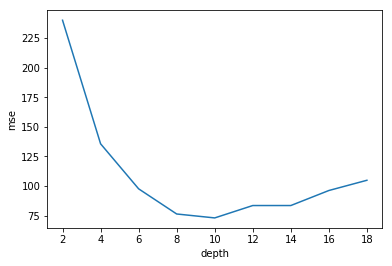

In [41]:
plt.plot(ds, mses)
#plt.plot(ds, mse_train)
plt.xlabel('depth')
plt.ylabel('mse')

In [43]:
best_model = models[ds.index(10)]
pred = best_model.transform(Xte)

In [46]:
pred = pred.select('*', (pred.prediction - pred.label).alias('error'))

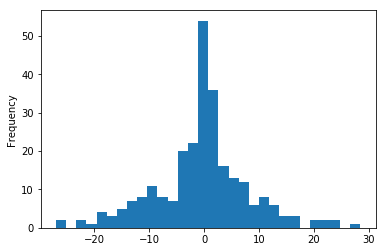

In [48]:
pred.toPandas().error.plot.hist(bins=30)

In [50]:
sigma = pred.agg(fn.stddev('error').alias('sigma')).collect()[0].sigma

In [53]:
pred = pred.select('*', (pred.error / sigma).alias('z'))

In [57]:
pred.filter(fn.abs(pred.z)>3).select('date', 'label', 'prediction', 'z').show()

+--------------------+-----+------------------+-------------------+
|                date|label|        prediction|                  z|
+--------------------+-----+------------------+-------------------+
|2015-08-27 11:00:...|   67|40.022222222222226|  -3.15166153437363|
|2015-08-24 17:00:...|  170|198.47826086956522|   3.32695450632701|
|2015-08-21 09:00:...|  149|122.68354430379746|-3.0744030076150093|
+--------------------+-----+------------------+-------------------+



In [64]:
df = pred.toPandas()

In [72]:
df = df.set_index('date').sort_index()

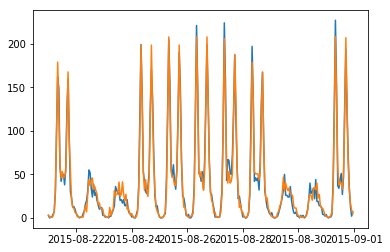

In [74]:
plt.plot(df.label)
plt.plot(df.prediction)

In [30]:
from pyspark.ml.regression import GBTRegressor

In [61]:
model = GBTRegressor().fit(Xtr)

In [62]:
pred = model.transform(Xte)
pred.agg(fn.mean((pred.label - pred.prediction)**2)).show()

+-----------------------------------+
|avg(POWER((label - prediction), 2))|
+-----------------------------------+
|                  83.63718015665134|
+-----------------------------------+



In [80]:
import pyspark.sql.functions as fn

In [91]:
X.agg(fn.max(X.date), fn.min(X.date)).show()

+--------------------+--------------------+
|           max(date)|           min(date)|
+--------------------+--------------------+
|2015-08-31 23:00:...|2014-09-29 00:00:...|
+--------------------+--------------------+



In [92]:
Xtr.count(), Xte.count()

(7824, 264)

In [93]:
prediction = model.transform(Xte)

In [94]:
prediction.show(5)

+--------------------+--------------------+-----+------------------+
|                date|            features|label|        prediction|
+--------------------+--------------------+-----+------------------+
|2015-08-27 11:00:...|[43.0,51.0,32.0,5...|   67| 43.85421294710714|
|2015-08-30 00:00:...|[2.0,4.0,3.0,2.0,...|    2| 3.345106034474709|
|2015-08-26 18:00:...|[199.0,151.0,129....|  139|133.61302191857968|
|2015-08-29 05:00:...|[0.0,6.0,1.0,3.0,...|    1|0.7622135948711529|
|2015-08-23 07:00:...|[2.0,8.0,3.0,6.0,...|    6| 6.083521688311659|
+--------------------+--------------------+-----+------------------+
only showing top 5 rows



In [128]:
model_result = prediction.select(
                  prediction.date,
                  prediction.label.alias('actual'),
                  prediction.prediction,
                  (prediction.prediction - prediction.label).alias('prediction error'))

In [123]:
stats = model_result.agg(fn.stddev_pop('prediction error').alias('sigma'),
                         fn.mean('prediction error')).collect()

In [124]:
stats

[Row(sigma=9.126043404991938, avg(prediction error)=-0.593727148490358)]

In [144]:
df = model_result.select((model_result['prediction error']/stats[0].sigma).alias('z'), *model_result.columns).toPandas()

In [145]:
df.head()

,z,date,actual,prediction,prediction error
0,-2.536235,2015-08-27 11:00:00,67,43.854213,-23.145787
1,0.147392,2015-08-30 00:00:00,2,3.345106,1.345106
2,-0.590286,2015-08-26 18:00:00,139,133.613022,-5.386978
3,-0.026056,2015-08-29 05:00:00,1,0.762214,-0.237786
4,0.009152,2015-08-23 07:00:00,6,6.083522,0.083522


In [146]:
%matplotlib inline

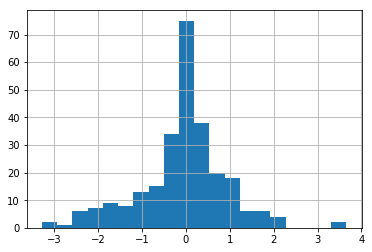

In [173]:
df.z.hist(bins=20)

In [142]:
from calendar import day_abbr, month_abbr

In [149]:
df['day'] = df.date.apply(lambda x: day_abbr[x.weekday()])
df['month'] = df.date.apply(lambda x: month_abbr[x.month])

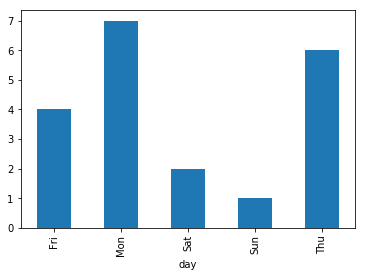

In [159]:
df[abs(df.z) > 2].groupby('day').size().plot.bar()

In [177]:
df = df.set_index('date').sort_index()

In [55]:
import matplotlib.pyplot as plt

In [174]:
plt.rcParams['figure.figsize'] = 12, 10

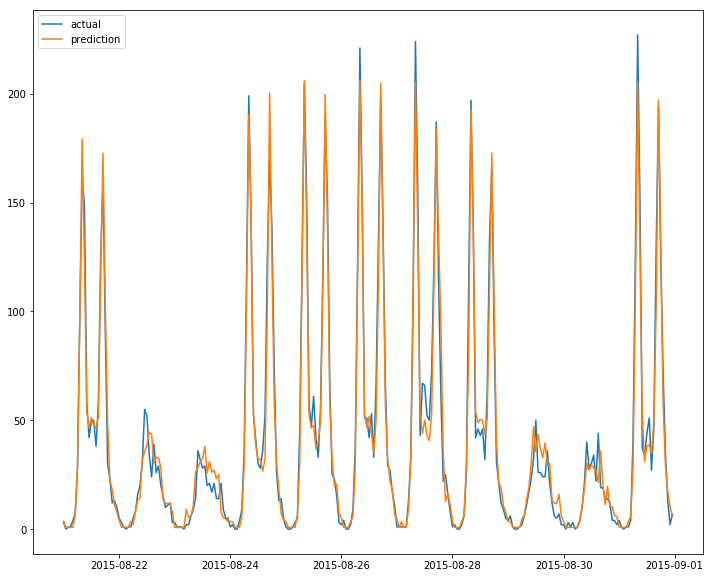

In [178]:
plt.plot(df.actual)
plt.plot(df.prediction)
plt.legend()
#ax = plt.gca().twinx()
#ax.plot(df.z, color='red', alpha=0.3)
plt.legend()

## Validation While Training